In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
import xarray as xr
import numpy as np
import os
import datetime
import shutil
import glob
import calendar
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tempfile
from PIL import Image

In [2]:
# List of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

current_data = 'datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'

In [8]:
fg = xr.open_dataset(current_data)
fg

<xarray.Dataset>
Dimensions:    (time: 168, depth: 2, latitude: 36, longitude: 100)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2023-12-01
  * depth      (depth) float32 -0.0 15.0
  * latitude   (latitude) float32 -1.875 -1.625 -1.375 ... 6.375 6.625 6.875
  * longitude  (longitude) float32 -14.88 -14.62 -14.38 ... 9.375 9.625 9.875
Data variables:
    ue         (time, depth, latitude, longitude) float32 ...
    ugos       (time, latitude, longitude) float32 ...
    ve         (time, depth, latitude, longitude) float32 ...
    vgos       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             Monthly mean total surface and 15m velocities
    institution:       CLS
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        Mulet S., Rio M.-H., Etienne H., Artana C., Cancet M.,...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  MULTIOBS_GLO_PHY_MYNRT_015_003
    subset:datasetId:  cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_202411
    subset:date:       2025-02-22T01:19:41.287Z

In [24]:
def plot_guinea_current(data_path, depth_level=0, unit='m/s', cmap='coolwarm'):
    """
    Plots the monthly climatology of the Guinea Current by combining the Ekman drift
    and geostrophic components. The total eastward and northward velocities are calculated
    as:
    
        total_eastward = ugeos + ue
        total_northward = vgeos + ve
        
    Parameters:
      data_path : str
          Path to the NetCDF dataset.
      depth_level : int or float
          Depth level to select (e.g., 0 for surface, 15 for 15m).
      unit : str
          Unit for the velocities.
      cmap : str
          Colormap for the contour plots.
    """
    # Open dataset
    ds = xr.open_dataset(data_path)

    ds = ds.sel(latitude=slice(2, 6.9))
    # Select the desired depth level (e.g., surface=0 or 15m)
    ds_depth = ds.sel(depth=depth_level)
    
    # Combine the Ekman drift and geostrophic components
    total_eastward = ds_depth['ugos'] + ds_depth['ue']
    total_northward = ds_depth['vgos'] + ds_depth['ve']
    
    # Compute total speed and direction
    speed = np.sqrt(total_eastward**2 + total_northward**2)
    direction = np.arctan2(total_northward, total_eastward) * (180 / np.pi)
    direction = (direction + 360) % 360  # Convert to range [0, 360)
    
    # Create monthly means (climatology) from monthly means (1ME = monthly end)
    monthly_speed = speed.resample(time='1ME').mean()
    monthly_eastward = total_eastward.resample(time='1ME').mean()
    monthly_northward = total_northward.resample(time='1ME').mean()
    
    # Extract coordinate variables
    lat = ds_depth['latitude']
    lon = ds_depth['longitude']
    
    # Create a 4x3 grid for 12 months
    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()})
    contour = None
    
    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]
        
        # Select data for the current month and average if needed
        sp_month = monthly_speed.sel(time=monthly_speed['time'].dt.month == (month_index + 1)).mean(dim='time')
        u_month = monthly_eastward.sel(time=monthly_eastward['time'].dt.month == (month_index + 1)).mean(dim='time')
        v_month = monthly_northward.sel(time=monthly_northward['time'].dt.month == (month_index + 1)).mean(dim='time')
        
        # Plot the total current speed as filled contours
        contour = sp_month.plot.contourf(
            ax=ax, cmap=cmap, add_colorbar=False,
            transform=ccrs.PlateCarree(), levels=20
        )
        
        # Downsample the grid for the quiver plot 
        skip = 5
        lon_ds = lon[::skip]
        lat_ds = lat[::skip]
        Lon, Lat = np.meshgrid(lon_ds, lat_ds)
        
        # Downsample the velocity fields to match the meshgrid shape
        u_ds = u_month[::skip, ::skip]
        v_ds = v_month[::skip, ::skip]
        
    
        ax.quiver(Lon, Lat, u_ds, v_ds, scale=5, color='black', transform=ccrs.PlateCarree())
        
        # Add map features
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={'bottom': 'x', 'left': 'y'})
        ax.set_title(f"{month_names[month_index]}", fontsize=12)
        
        # Set extent to focus on the Gulf of Guinea region
        ax.set_extent([-11, 10, 2, 7], crs=ccrs.PlateCarree())
    
    # For a horizontal colorbar
    # cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.02])
    # fig.colorbar(contour, cax=cbar_ax, orientation='horizontal', label=f'Current Speed ({unit})')

    # For a vertical colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])   
    fig.colorbar(contour, cax=cbar_ax, orientation='vertical', label=f'Current Speed ({unit})')
    
    plt.suptitle(f'Monthly Climatology of the Guinea Current (Depth {depth_level} m)', y=0.99, fontsize=14)
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(f'Guinea_Current_Climatology_{depth_level}.png')
    plt.savefig("figures/guinea_current.png", bbox_inches='tight', dpi=300)

    plt.show()
    
    # Close the dataset
    ds.close()



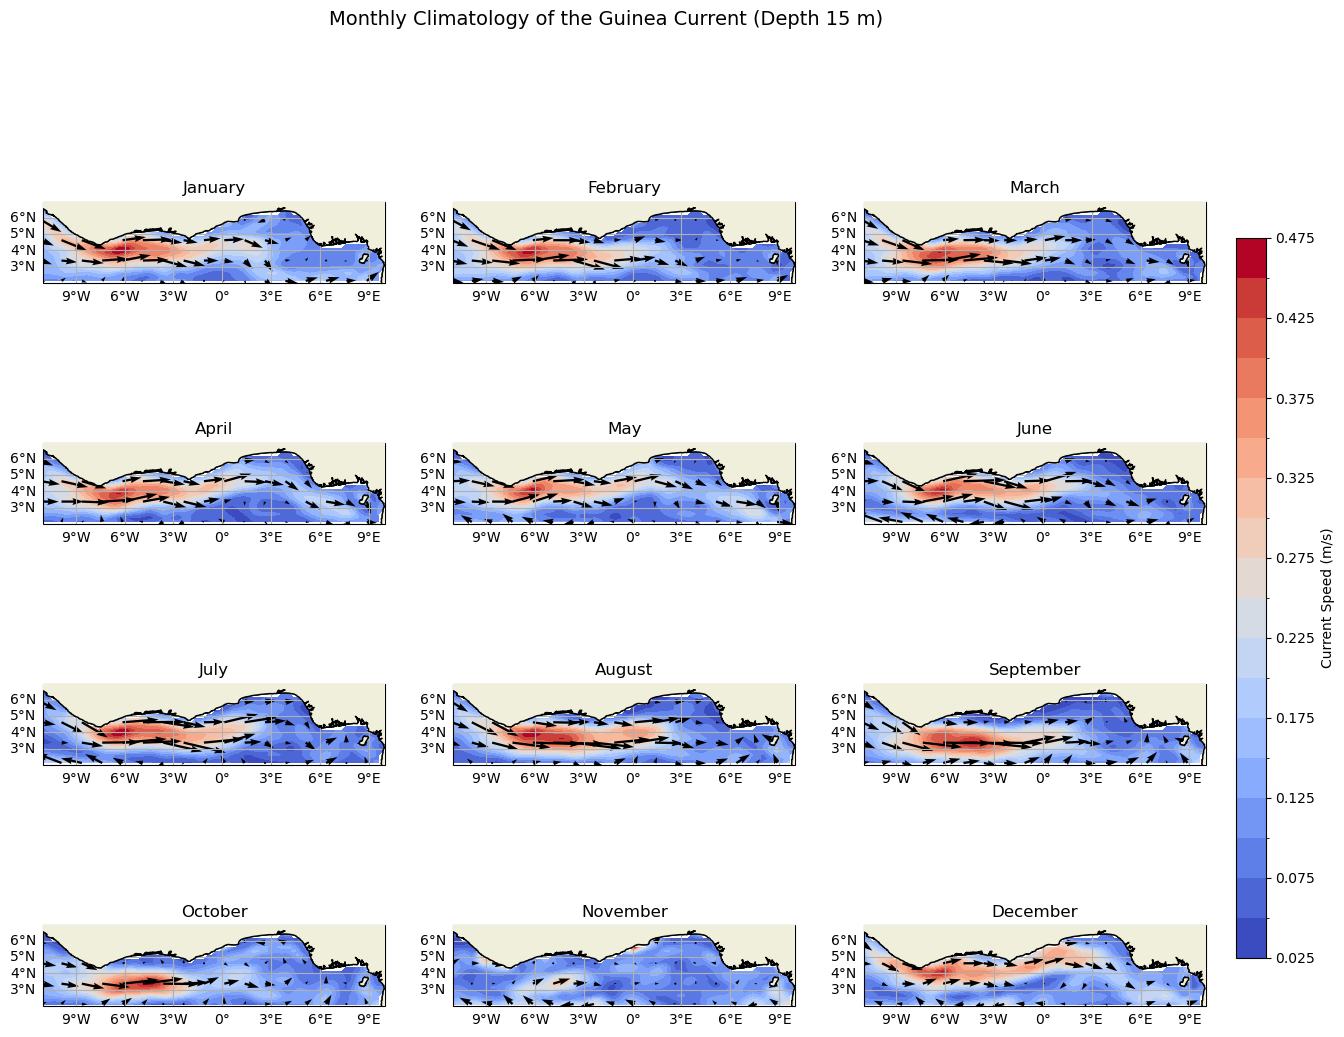

In [25]:
# Call
plot_guinea_current(current_data, depth_level=15)  # Use depth_level=15 for 15 m data if needed


In [6]:

def make_transparent_gif_from_monthly(data_path,
                                      out_gif="guinea_current_transparent.gif",
                                      depth_level=15,
                                      cmap='coolwarm',
                                      skip=6,
                                      duration_per_frame=1.0,   # seconds per month/frame
                                      lon_extent=[-9,10],
                                      lat_min=2,
                                      lat_max=10,
                                      arrow_scale_factor=6.0,
                                      min_arrow_alpha=0.12):
    """
    Create a GIF with transparent background by:
      1) rendering each monthly frame to a transparent PNG (bbox_inches='tight'),
      2) converting PNG frames to paletted GIF frames with an explicit transparency index,
      3) saving assembled GIF.

    Note: GIF transparency is binary (fully transparent pixels) and may show dithering
          at the alpha edges. For slides, this usually looks fine.
    """
    # --- Load data and compute monthly climatology (same logic as before) ---
    ds = xr.open_dataset(data_path)
    ds_depth = ds.sel(depth=depth_level)

    u_total = ds_depth['ugos'] + ds_depth['ue']
    v_total = ds_depth['vgos'] + ds_depth['ve']
    speed = np.sqrt(u_total**2 + v_total**2)

    monthly_speed = speed.resample(time='1ME').mean()
    monthly_u = u_total.resample(time='1ME').mean()
    monthly_v = v_total.resample(time='1ME').mean()

    months_present = np.unique(monthly_speed['time'].dt.month.values)
    months = [m for m in range(1,13) if m in months_present]
    if len(months) == 0:
        raise ValueError("No monthly data found after resampling.")
    month_names = [calendar.month_abbr[m] for m in months]

    # coords
    lat = ds_depth['latitude'].values
    lon = ds_depth['longitude'].values

    lon_ds = lon[::skip]
    lat_ds = lat[::skip]
    Lon_quiv, Lat_quiv = np.meshgrid(lon_ds, lat_ds)

    Lon2D, Lat2D = np.meshgrid(lon, lat)

    # global colorbar limits
    vmin = float(monthly_speed.min(dim='time').min().values)
    vmax = float(monthly_speed.max(dim='time').max().values)
    global_max_speed = float(monthly_speed.max().values)
    scale = max(global_max_speed * arrow_scale_factor, 1e-8)

    # temp directory to hold PNG frames
    tmpdir = tempfile.mkdtemp(prefix="guinea_frames_")
    print("Saving PNG frames to:", tmpdir)

    # --- Build figure once and draw frames, saving each as transparent PNG ---
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    ax.set_extent([lon_extent[0], lon_extent[1], lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

    # Make figure and axes background transparent
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)

    # prepare colorbar axis using make_axes_locatable so it matches ax height (optional)
    try:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.02)
        cax.patch.set_alpha(0.0)
    except Exception:
        # fallback: create a small axis manually (still set transparent)
        # cbar_ax = fig.add_axes([0.92, 0.32, 0.02, 0.34])  # tall vertical colorbar
        cax = fig.add_axes([0.92, 0.32, 0.02, 0.34])
        cax.patch.set_alpha(0.0)

    # loop months, draw, save PNG
    saved_files = []
    current_contour = None
    current_quiv = None
    title = ax.set_title("", fontsize=16, pad=12)

    for i, m in enumerate(months):
        month_label = calendar.month_abbr[m]

        sp = monthly_speed.sel(time=monthly_speed['time'].dt.month == m).mean(dim='time')
        u = monthly_u.sel(time=monthly_u['time'].dt.month == m).mean(dim='time')
        v = monthly_v.sel(time=monthly_v['time'].dt.month == m).mean(dim='time')

        # remove previous
        if current_contour is not None:
            try:
                current_contour.remove()
            except Exception:
                pass
        if current_quiv is not None:
            try:
                current_quiv.remove()
            except Exception:
                pass

        # contour (vmin/vmax fixed)
        current_contour = ax.contourf(Lon2D, Lat2D, sp, levels=20, cmap=cmap,
                                      vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), zorder=1)

        # quiver (downsampled)
        u_ds = u[::skip, ::skip].values
        v_ds = v[::skip, ::skip].values
        sp_ds = np.sqrt(u_ds**2 + v_ds**2)

        if sp_ds.max() > 0:
            alpha_ds = np.clip(sp_ds / sp_ds.max(), min_arrow_alpha, 1.0)
        else:
            alpha_ds = np.full_like(sp_ds, min_arrow_alpha)

        rgba = np.zeros((sp_ds.size, 4))
        rgba[:, 0:3] = 0.0
        rgba[:, 3] = alpha_ds.ravel()

        current_quiv = ax.quiver(Lon_quiv, Lat_quiv, u_ds, v_ds, color=rgba,
                                 scale=scale, transform=ccrs.PlateCarree(), zorder=2, angles='xy')

        # colorbar: create just once (first iteration) inside cax, and reuse
        if i == 0:
            # ensure cax is transparent
            cax.patch.set_alpha(0.0)
            cbar = fig.colorbar(current_contour, cax=cax, orientation='vertical')
            cbar.set_label(f'Current Speed (m/s)')

        # title
        title.set_text(month_label)

        # ensure everything is drawn, then save PNG with transparent background and tight bbox
        # pad_inches=0 removes extra whitespace
        fname = os.path.join(tmpdir, f"frame_{i:02d}.png")
        fig.savefig(fname, bbox_inches='tight', pad_inches=0, transparent=True)
        saved_files.append(fname)
        print("Saved", fname)

    # --- Assemble PNGs into GIF preserving transparency using Pillow ---
    print("Assembling GIF from PNG frames...")
    pil_frames = []
    for fname in saved_files:
        im = Image.open(fname).convert('RGBA')  # keep alpha
        # convert to P (palette) with 255 colors, leaving index 255 for transparency
        im_p = im.convert('P', palette=Image.ADAPTIVE, colors=255)
        # identify fully transparent pixels in the original alpha channel
        alpha = im.split()[3]
        mask = Image.eval(alpha, lambda a: 255 if a <= 0 else 0)
        # paste index 255 (the chosen transparency index) where mask==255
        im_p.paste(255, box=None, mask=mask)
        pil_frames.append(im_p)

    if len(pil_frames) == 0:
        raise RuntimeError("No frames were created.")

    # save GIF with transparency index=255 and disposal=2 (restore to background)
    pil_frames[0].save(
        out_gif,
        save_all=True,
        append_images=pil_frames[1:],
        duration=int(duration_per_frame * 1000),
        loop=0,
        transparency=255,
        disposal=2,
        optimize=False
    )
    print("Saved transparent GIF to:", out_gif)

    # cleanup temp pngs
    try:
        shutil.rmtree(tmpdir)
    except Exception:
        pass

    ds.close()



Saving PNG frames to: C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_00.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_01.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_02.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_03.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_04.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_05.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_06.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_07.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_08.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_09.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea_frames_vux92fwg\frame_10.png
Saved C:\Users\Annorion\AppData\Local\Temp\guinea

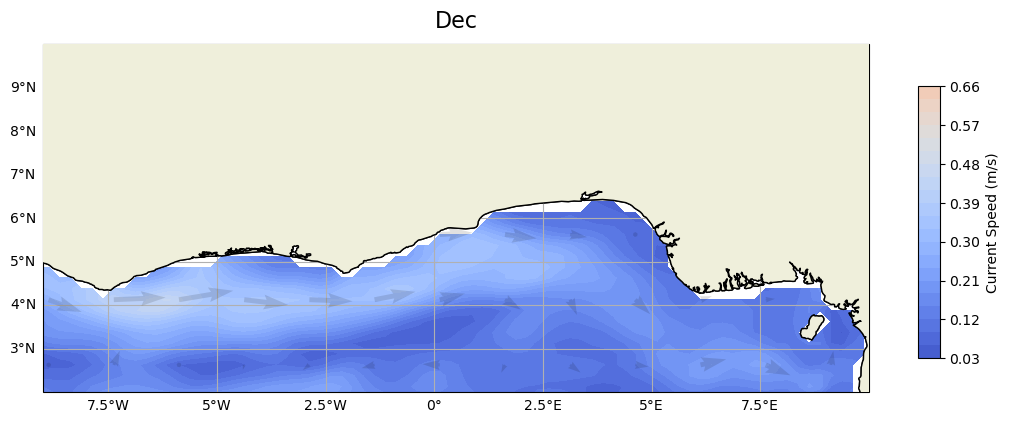

In [7]:
# Example call:
make_transparent_gif_from_monthly(f"{current_data}", out_gif="figures/Guinea_current_transparent.gif",
                                  depth_level=15, skip=6, duration_per_frame=1.0)


In [14]:

def plot_guinea_current_decomposition(
    ds,
    lat_range=(1, 6),          # coastal band (°N)
    lon_range=(-10, 10),       # coastal band (°E)
    ekman_top=15,              # average Ekman drift over top N meters
    figpath="figures/surface_currents.png",
    title="Surface Currents"
):
    """
    Expects variables:
      ue(time, depth, latitude, longitude)   [m/s]  east Ekman drift
      ve(time, depth, latitude, longitude)   [m/s]  north Ekman drift
      ugos(time, latitude, longitude)        [m/s]  east geostrophic (surface)
      vgos(time, latitude, longitude)        [m/s]  north geostrophic (surface)
    """

    # --- Subset to coastal box
    dsB = ds.sel(latitude=slice(*lat_range), longitude=slice(*lon_range))

    # --- Ekman drift at surface (mean of top ekman_top m, or nearest if discrete)
    if 'depth' in dsB.ue.coords:
        if np.issubdtype(dsB.depth.dtype, np.number):
            top_mask = dsB.depth <= ekman_top
            if top_mask.any():
                ue_sfc = dsB.ue.where(top_mask, drop=True).mean('depth')
                ve_sfc = dsB.ve.where(top_mask, drop=True).mean('depth')
            else:  # fall back to first level
                ue_sfc = dsB.ue.isel(depth=0)
                ve_sfc = dsB.ve.isel(depth=0)
        else:  # non-numeric depth labels → take first level
            ue_sfc = dsB.ue.isel(depth=0)
            ve_sfc = dsB.ve.isel(depth=0)
    else:
        raise ValueError("Ekman variables (ue, ve) need a 'depth' coordinate.")

    # --- Geostrophic surface components
    ug = dsB.ugos
    vg = dsB.vgos

    # --- Speeds
    speed_ek = np.hypot(ue_sfc, ve_sfc)
    speed_geo = np.hypot(ug, vg)
    # Total surface current ≈ geostrophic + Ekman components
    u_tot = ug + ue_sfc
    v_tot = vg + ve_sfc
    speed_tot = np.hypot(u_tot, v_tot)

    # --- Coastal-band spatial mean
    dims_space = [d for d in speed_tot.dims if d not in ('time',)]
    speed_ek_idx  = speed_ek.mean(dims_space)
    speed_geo_idx = speed_geo.mean(dims_space)
    speed_tot_idx = speed_tot.mean(dims_space)

    # --- Monthly climatology
    ek_mon  = speed_ek_idx.groupby('time.month').mean('time')
    geo_mon = speed_geo_idx.groupby('time.month').mean('time')
    tot_mon = speed_tot_idx.groupby('time.month').mean('time')

    # --- Plot
    months = np.arange(1, 13)
    labels = [calendar.month_abbr[m] for m in months]

    plt.figure(figsize=(10, 5.5))
    plt.plot(months, tot_mon.values,  '-o',  label='Total Currents',            linewidth=2)
    plt.plot(months, geo_mon.values,  '-s',  label='Geostrophic Currents',      linewidth=2)
    plt.plot(months, ek_mon.values,   '-x',  label='Ekman Drift Currents',      linewidth=2)

    plt.xticks(months, labels, rotation=45, ha='right')
    plt.grid(True, alpha=0.4)
    plt.ylabel('Velocity (m/s)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(figpath, dpi=150)
    plt.show()

    return {
        "monthly_total": tot_mon,
        "monthly_geos":  geo_mon,
        "monthly_ekman": ek_mon
    }

# --- Example usage ---
# ds = xr.open_dataset("your_dataset.nc")
# out = plot_guinea_current_decomposition(ds,
#                                         lat_range=(1,6), lon_range=(-10,10),
#                                         ekman_top=15,
#                                         figpath="figures/surface_currents.png",
#                                         title="Surface Currents")


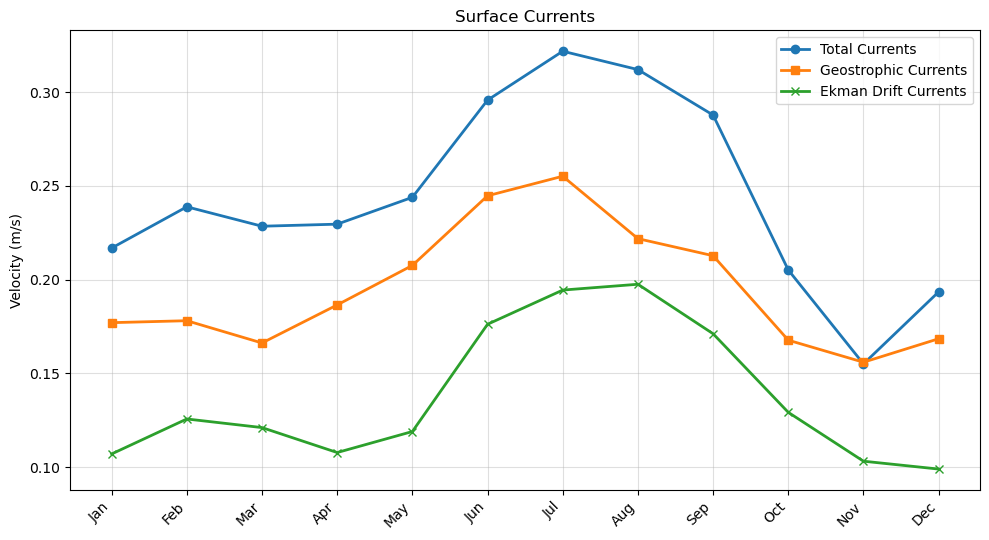

In [15]:
ds = xr.open_dataset("datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc")
out = plot_guinea_current_decomposition(ds,
                                         lat_range=(1,6), lon_range=(-10,10),
                                         ekman_top=15,
                                         figpath="figures/surface_currents.png",
                                         title="Surface Currents")
